# Demo - Fairness Analysis of FICO

Adapted version of:

1. Fairness and machine learning book - [Chapter 2](https://fairmlbook.org/demographic.html) and [code repository](https://github.com/fairmlbook/fairmlbook.github.io).

2. Hardt, M., Price, E., & Srebro, N. (2016). [Equality of opportunity in supervised learning](https://arxiv.org/abs/1610.02413). In Advances in neural information processing systems (pp. 3315-3323).

3. [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/) by Google

From [Wikipeida](https://en.wikipedia.org/wiki/Credit_score_in_the_United_States):
> Credit score in the United States is a number representing the creditworthiness of a person, the likelihood that person will pay his or her debts.  
Lenders, such as banks and credit card companies, use credit scores to evaluate the potential risk posed by lending money to consumers. Lenders allege that widespread use of credit scores has made credit more widely available and less expensive for many consumers


The analysis is based on data from [Report to the Congress on Credit Scoring and Its Effects on the Availability and Affordability of Credit](https://federalreserve.gov/boarddocs/rptcongress/creditscore/) by the Federal Reserve. The data set provides aggregate statistics from 2003 about a credit score, demographic information (race or ethnicity, gender, marital status), and outcomes (to be defined shortly). 


In the USA there are three majour creding agencies, which are for-profit organizations. They offer risk score based on the data they collected. Wre are going to look into **FICO** score of TransUnion (called TransRisk). The TransRisk score is in turn based on a proprietary model created by FICO, hence often referred to as FICO scores. 


![Factors contributing to someone's credit score](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Credit-score-chart.svg/640px-Credit-score-chart.svg.png)
<small>Source: Wikipedia</small>


From Fairness and Machine Learning - Limitations and Opportunities:
> Regulation of credit agencies in the United States started with the Fair Credit Reporting Act, first passed in 1970, that aims to promote the accuracy, fairness, and privacy of consumer of information collected by the reporting agencies. The Equal Credit Opportunity Act, a United States law enacted in 1974, makes it unlawful for any creditor to discriminate against any applicant the basis of race, color, religion, national origin, sex, marital status, or age.

### In our analysis we'll use on the joint statistics of score, race, and outcome.

In [1]:
import pandas as pd
import matplotlib.pylab as plt

from responsibly.fairness.metrics import plot_roc_curves
from responsibly.fairness.interventions.threshold import (find_thresholds,
                                                        plot_fpt_tpr,
                                                        plot_roc_curves_thresholds,
                                                        plot_costs)

### FICO Dataset

FICO dataset can be loaded directly from `responsibly`. The dataset, in this case, is *aggregate*, i.e., there is no outcome and prediction information per individual, but summarized statistics for each FICO score and race/race/ethnicity group.

In [2]:
from responsibly.dataset import build_FICO_dataset

FICO = build_FICO_dataset()

`FICO` is a dictionary that holds variaty of data:

In [3]:
FICO.keys()

dict_keys(['base_rates', 'aucs', 'performance', 'proportions', 'pdf', 'tpr', 'rocs', 'fpr', 'totals', 'cdf', 'base_rate'])

In [4]:
help(build_FICO_dataset)

Help on function build_FICO_dataset in module responsibly.dataset.fico:

build_FICO_dataset()
    Build the FICO dataset.
    
    Dataset of the credit score of TransUnion (called TransRisk).
    The TransRisk score is in turn based on
    a proprietary model created by FICO,
    hence often referred to as FICO scores.
    
    The data is *aggregated*, i.e., there is no outcome
    and prediction information per individual,
    but summarized statistics for each FICO score
    and race/race/ethnicity group.
    
    +---------------+------------------------------------------------------+
    | FICO key      | Meaning                                              |
    +===============+======================================================+
    | `totals`      | Number of individuals per group                      |
    +---------------+------------------------------------------------------+
    | `cdf`         | Cumulative distribution function of score per group  |
    +-------------

### Counts by Race or Ethnicity

In [5]:
sum(FICO['totals'].values())

174047

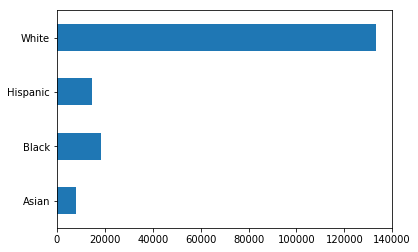

In [6]:
pd.Series(FICO['totals']).plot(kind='barh');

### Score Distribution

The score used in the study is based on the TransUnion TransRisk score. TransUnion is a US credit-reporting agency. The TransRisk score is in turn based on a proprietary model created by FICO, hence often referred to as FICO scores. The Federal Reserve renormalized the scores for the study to vary from 0 to 100, with 0 being least creditworthy.

The information on race was provided by the Social Security Administration, thus relying on self-reported values.

The cumulative distribution of these credit scores strongly depends on the group as the next figure reveals.

In [7]:
FICO['cdf'].head()

,Asian,Black,Hispanic,White
Score,,,,
0.0,0.0000,0.0007,0.0001,0.0001
0.5,0.0013,0.0119,0.0047,0.0026
1.0,0.0088,0.0533,0.0222,0.0116
1.5,0.0107,0.0647,0.0274,0.0143
2.0,0.0132,0.0789,0.0349,0.0180


In [8]:
FICO['cdf'].tail()

,Asian,Black,Hispanic,White
Score,,,,
98.0,0.9894,0.9989,0.9966,0.9894
98.5,0.9961,0.9995,0.9988,0.9962
99.0,0.9989,0.9999,0.9998,0.9991
99.5,0.9994,1.0000,1.0000,0.9998
100.0,1.0000,1.0000,1.0000,1.0000


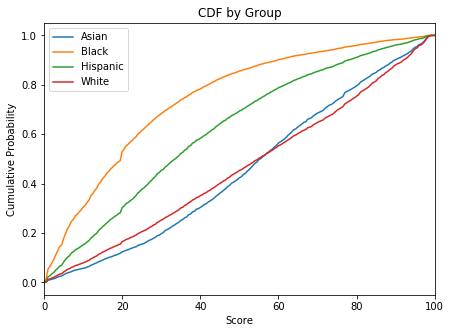

In [9]:
f, ax = plt.subplots(1, figsize=(7, 5))

FICO['cdf'].plot(ax=ax)

plt.title('CDF by Group')
plt.ylabel('Cumulative Probability');

### Outcome Variable

**Performance variable** that measures a serious delinquency in at least one credit line of a certain time period:

> "(the) measure is based on the performance of new or existing accounts and measures whether individuals have been late 90 days or more on one or more of their accounts or had a public record item or a new collection agency account during the performance period." - *from the Federal Reserve report*

The `FICO['performance']` holds the percentage of non-defaulters for every score value (rows) and race/ethnicity group (columns):

In [10]:
FICO['performance'].head()

,Asian,Black,Hispanic,White
Score,,,,
0.0,0.0523,0.0033,0.0095,0.0146
0.5,0.0552,0.0077,0.0151,0.0205
1.0,0.0581,0.0120,0.0207,0.0264
1.5,0.0610,0.0164,0.0262,0.0323
2.0,0.0639,0.0207,0.0318,0.0382


In [11]:
FICO['performance'].tail()

,Asian,Black,Hispanic,White
Score,,,,
98.0,0.9916,0.9818,0.9891,0.9899
98.5,0.9917,0.9840,0.9897,0.9902
99.0,0.9918,0.9861,0.9902,0.9905
99.5,0.9920,0.9882,0.9908,0.9907
100.0,0.9921,0.9904,0.9913,0.9910


### Separation Fairness Criterion
By the separation criterion of a binary classifier, the *FPR* and *TPR* should be equal across the groups.

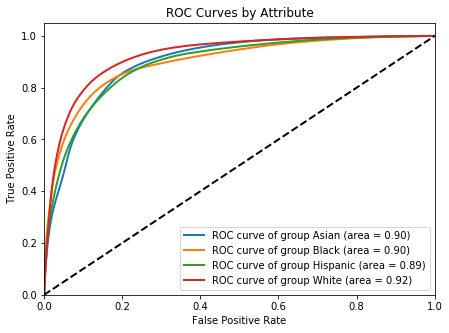

In [12]:
plot_roc_curves(FICO['rocs'], FICO['aucs'],
                figsize=(7, 5));

The meaning of true positive rate is the rate of predicted positive performance given positive performance. Similarly, false positive rate is the rate of predicted negative performance given a positive performance.

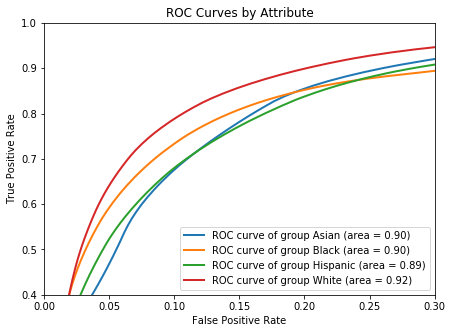

In [13]:
plot_roc_curves(FICO['rocs'], FICO['aucs'],
                figsize=(7, 5));

plt.xlim(0, 0.3)
plt.ylim(0.4, 1);

### Thresholds vs. FPR and TPR

The ROC is paramaritazied over the thershold, so the same threshold might be related to different (FPR, TPR) pairs for each group. We can observe it by plotting the FPR and the TPR as a function of the threshold by the groups.

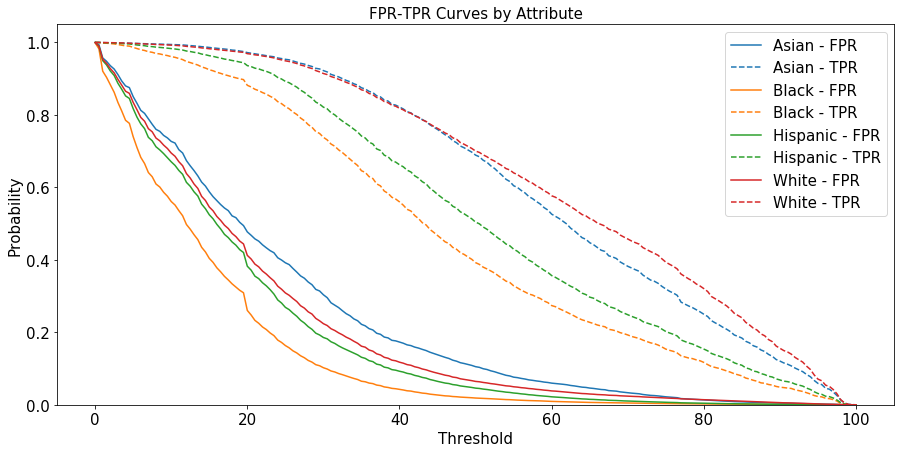

In [14]:
plot_fpt_tpr(FICO['rocs'], figsize=(15, 7),
             title_fontsize=15, text_fontsize=15);

Therefore, a naive choice of a single threshold will cause to a violation of the separation fairness criterion, as there will be different in FPR and TPR between the groups.

### Comparison of Different Criteria

* Single threshold (Group Unaware)
* Minimum Cost
* Independence (Demographic Parity)
* FNR (Equality of opportunity)
* Separation (Equalized odds)

#### Cost: $FP = - 5 \cdot TP$

In [15]:
COST_MATRIX = [[0, -5/6],
               [0,  1/6]]

In [16]:
thresholds_data = find_thresholds(FICO['rocs'],
                                  FICO['proportions'],
                                  FICO['base_rate'],
                                  FICO['base_rates'],
                                  COST_MATRIX)

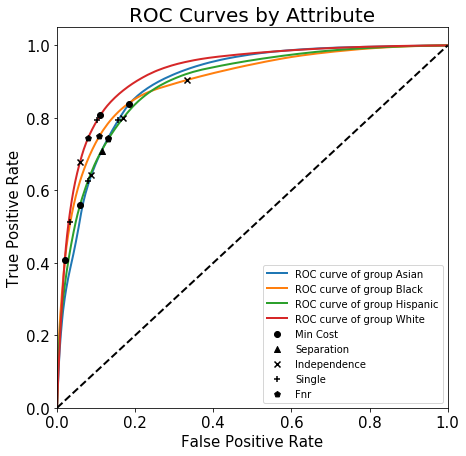

In [17]:
plot_roc_curves_thresholds(FICO['rocs'], thresholds_data,
                           figsize=(7, 7),
                           title_fontsize=20, text_fontsize=15);

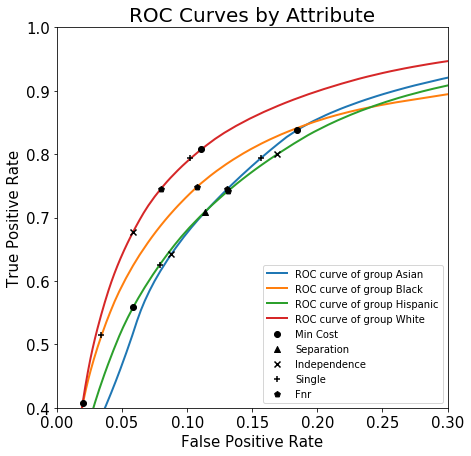

In [18]:
plot_roc_curves_thresholds(FICO['rocs'], thresholds_data,
                           figsize=(7, 7),
                           title_fontsize=20, text_fontsize=15)

plt.xlim(0, 0.3)
plt.ylim(0.4, 1);

### Cost by Threshold Strategy

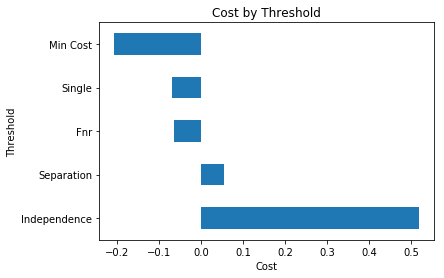

In [19]:
plot_costs(thresholds_data);

### Sufficiency Fairness Criterion - Calibration

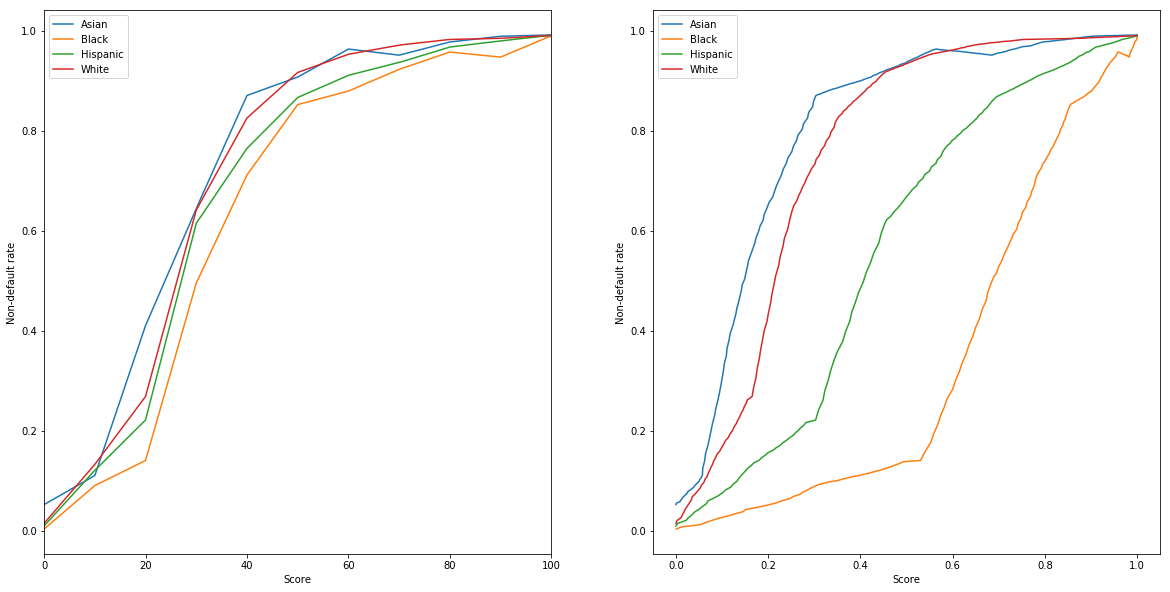

In [20]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

FICO['performance'].plot(ax=axes[0])
axes[0].set_ylabel('Non-default rate')

for group in FICO['cdf'].columns:
    axes[1].plot(FICO['cdf'][group], FICO['performance'][group],
             label=group)
    
axes[1].set_ylabel('Non-default rate')
axes[1].set_xlabel('Score')
axes[1].legend();

Due to the differences in score distribution by group, it could nonetheless be the case that thresholding the score leads to a classifier with different positive predictive values in each group.